# Generating splits for BioKG

Continuing from the `00-clean-biokg-benchmarks` notebook, here we will generate
the training, validation, and test splits for the *transductive* version of BioKG.

In [1]:
import os.path as osp

import pandas as pd
from pykeen.triples import TriplesFactory
import matplotlib.pyplot as plt

## Splitting triples with PyKEEN

In [2]:
output_dir = osp.join('..', 'data', 'biokgb')
kg_output_dir = osp.join(output_dir, 'graph')
biokg_filename = 'biokg.links.csv'

biokg = TriplesFactory.from_path(osp.join(kg_output_dir, biokg_filename))

def print_triples_statistics(triples_factory):
    print(f'{"Triples":10}{triples_factory.num_triples:>12,}')
    print(f'{"Entities":10}{triples_factory.num_entities:>12,}')
    print(f'{"Relations":10}{triples_factory.num_relations:>12,}')

print('BioKG statistics:')
print_triples_statistics(biokg)

BioKG statistics:
Triples      1,852,262
Entities       106,047
Relations           17


To ensure reproducibility, we set a random seed before splitting.

In [3]:
training, validation, test = biokg.split(ratios=[0.8, 0.1, 0.1], random_state=0)

## Analysis of splits

In [4]:
for split, triples in {'Training': training, 'Validation': validation, 'Test': test}.items():
    print(f'{split} statistics:')
    print('-'*22)
    print_triples_statistics(triples)
    print()

Training statistics:
----------------------
Triples      1,481,809
Entities       106,047
Relations           17

Validation statistics:
----------------------
Triples        185,226
Entities       106,047
Relations           17

Test statistics:
----------------------
Triples        185,227
Entities       106,047
Relations           17



In [5]:
train_df, valid_df, test_df = (pd.DataFrame(t.triples) for t in (training, validation, test))

Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


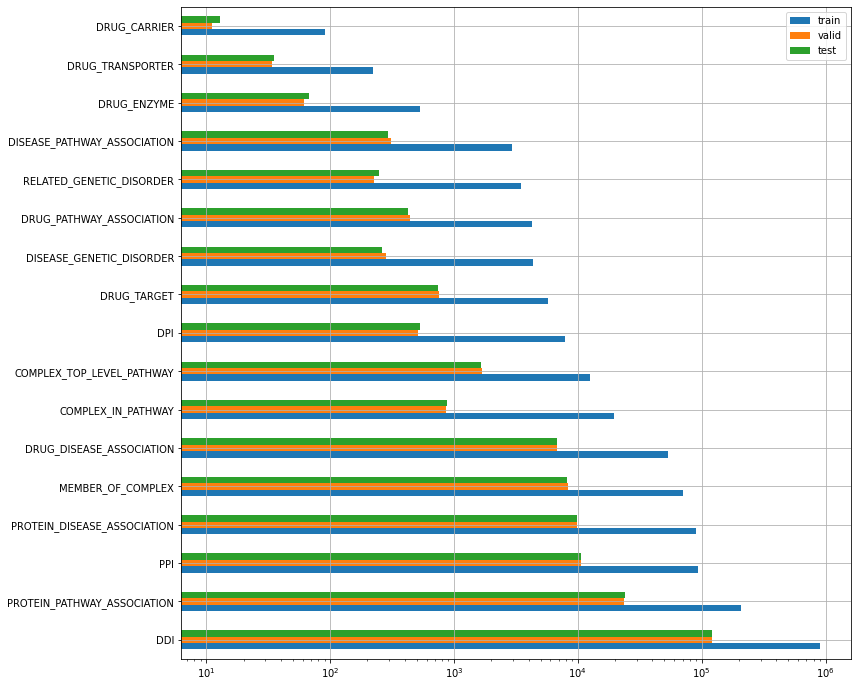

In [6]:
relation_counts_all_splits = pd.concat([df[1].value_counts() for df in [train_df, valid_df, test_df]], axis=1)
relation_counts_all_splits.columns = ['train', 'valid', 'test']
relation_counts_all_splits.plot.barh(logx=True, grid=True, figsize=(12, 12));

Some things we can notice at this point:

- The relation counts in the validation and test sets are proportional to what is in the training set.
- The counts among relations can vary significantly:
  - For DDIs we have almost a million triples
  - For most, we have between 100s and 100s of thousands.
  - `DRUG_CARRIER` is pretty scarce, at around tens.

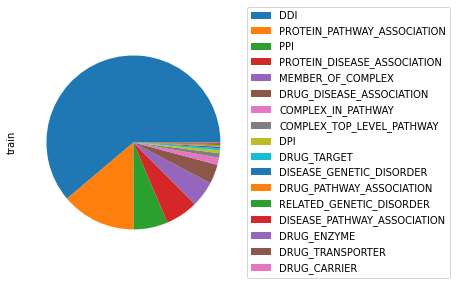

In [7]:
relation_counts_all_splits[['train']].plot.pie(y='train', labeldistance=None)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

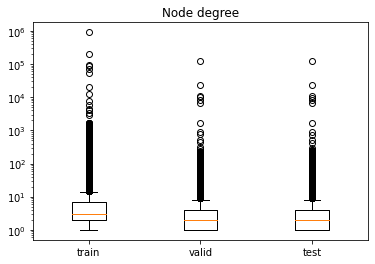

In [8]:
degree_counts = [pd.concat([df[0], df[1]], axis=0).value_counts().values for df in (train_df, valid_df, test_df)]

plt.boxplot(degree_counts, showfliers=True, labels=['train', 'valid', 'test'])
plt.title('Node degree')
plt.yscale('log')

## Exporting the splits

To facilitate sharing these splits, we will save them also as csv files,
using the original entity and relation identifiers.

In [9]:
for split, df in {'train': train_df, 'valid': valid_df, 'test': test_df}.items():
    filename = osp.splitext(biokg_filename)[0] + f'-{split}.csv'
    df.to_csv(osp.join(kg_output_dir, filename), sep='\t', index=False, header=False)